<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Explaining Language Models using SMILE </b></div>

Large language models like GPT, LLAMA, and Claude have become incredibly powerful at generating text, but they are still black boxes, so it is hard to understand how they decide what to say. That lack of transparency can be problematic, especially in fields where trust and accountability matter. To help with this, we introduce SMILE, a new method that explains how these models respond to different parts of a prompt. SMILE is model-agnostic and works by slightly changing the input, measuring how the output changes, and then highlighting which words had the most impact. Create simple visual heat maps showing which parts of a prompt matter the most. We tested SMILE on several leading LLMs and used metrics such as accuracy, consistency, stability, and fidelity to show that it gives clear and reliable explanations. By making these models easier to understand, SMILE brings us one step closer to making AI more transparent and trustworthy.

In this notebook, we apply SMILE to GPT-3.5 using the sentence: "What is the meaning of life?" to demonstrate its effectiveness.



# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Required Libraries</b></div>

In [1]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.70.0
    Uninstalling openai-1.70.0:
      Successfully uninstalled openai-1.70.0


In [2]:
!pip install sentence-transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.4 MB/s eta 0:00:00


In [3]:
!pip install pot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.6 MB/s eta 0:00:00


In [4]:
import openai


import scipy.special
import itertools

from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
from matplotlib import cm, transforms
from gensim.models import KeyedVectors

import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_20newsgroups

from scipy.stats import wasserstein_distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
from IPython.display import display
from kaggle_secrets import UserSecretsClient


2025-06-02 17:36:33.212836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748885793.497523      14 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748885793.570827      14 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load OpenAI API key from Kaggle Secrets
user_secrets = UserSecretsClient()
openai.api_key = user_secrets.get_secret("OPENAI_API_KEY")


<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Function to query OpenAI’s GPT-3.5-turbo-instruct model</b></div>

In [6]:
# Define a function to query GPT-3.5-turbo-instruct
def gpt_query(text):
    try:
        response = openai.Completion.create(
            model='gpt-3.5-turbo-instruct',
            prompt=text,
            max_tokens=100,
            temperature=0
        )
        return response.choices[0].text.strip()
    except Exception as e:
        return f"Error: {e}"


In [7]:
# Set prompt and get model output
prompt = "What is the meaning of life?"
Chat_GPT_Output = gpt_query(prompt)

# Display the result
print(Chat_GPT_Output)


The meaning of life is a philosophical question that has been debated by many thinkers and scholars throughout history. It is a complex and subjective concept that can have different interpretations and meanings for different individuals. Some believe that the meaning of life is to find happiness and fulfillment, while others believe it is to fulfill a certain purpose or destiny. Some see it as a journey of self-discovery and personal growth, while others see it as a way to contribute to the greater good of society. Ultimately, the meaning


<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b> Prompt Perturbation and GPT Response Analysis</b></div>

We generate 64 random perturbations of the original prompt by selectively including or excluding words. Each perturbed prompt is sent to GPT-3.5-turbo, and the resulting one-word outputs are collected.

This helps analyze the model’s sensitivity to different input combinations and prepares data for attribution scoring.

In [8]:
words = prompt.split()
words
seed = 1024
def perturb_text(text_list, perturbation, rng):
    # Select words based on the perturbation flag (1 means include)
    perturbed_list_initial = [item for item, flag in zip(text_list, perturbation) if flag == 1 and item.strip() != ""]
    
    # If no words were selected, force-select at least two words
    if len(perturbed_list_initial) < 2:
        additional_words_needed = 2
        available_words = [item for item in text_list if item.strip() != ""]
        additional_words = rng.choice(available_words, additional_words_needed, replace=False)
        perturbed_list = list(set(perturbed_list_initial + list(additional_words)))
    else:
        perturbed_list = list(set(perturbed_list_initial))
    
    return perturbed_list

# Example text input
text_list = words.copy()

num_perturb = 64  # Number of perturbations to generate
num_words = len(words)

Responses = []
Perturbations = []
unique_perturbations = set()
rng = np.random.default_rng(seed)

# Try up to a certain number of attempts to generate unique perturbations
attempts = 0
max_attempts = num_perturb * 10  # Allow 10 attempts per unique perturbation

# Loop for unique perturbations only
while len(unique_perturbations) < num_perturb and attempts < max_attempts:
    perturbation = tuple(rng.binomial(1, 0.5, size=num_words))
    if perturbation not in unique_perturbations and sum(perturbation) > 0:
        unique_perturbations.add(perturbation)
        perturbed_txt = perturb_text(text_list, perturbation, rng)
        corpus = ' '.join(perturbed_txt)
        Responses.append(corpus)
        Perturbations.append(perturbation)
        print(f"Perturbation: {perturbation}, Perturbed Text: {corpus}")
    attempts += 1

# If more perturbations are needed, allow repeats by sampling from unique_perturbations
while len(Responses) < num_perturb:
    perturbation = rng.choice(list(unique_perturbations))
    perturbed_txt = perturb_text(text_list, perturbation, rng)
    corpus = ' '.join(perturbed_txt)
    Responses.append(corpus)
    Perturbations.append(perturbation)
    print(f"Perturbation (reused): {perturbation}, Perturbed Text: {corpus}")


Perturbation: (0, 0, 0, 1, 1, 0), Perturbed Text: meaning of
Perturbation: (1, 1, 1, 0, 1, 0), Perturbed Text: What of the is
Perturbation: (1, 0, 1, 0, 1, 1), Perturbed Text: What of life? the
Perturbation: (0, 1, 1, 1, 0, 0), Perturbed Text: meaning the is
Perturbation: (1, 0, 0, 0, 0, 1), Perturbed Text: What life?
Perturbation: (1, 1, 1, 1, 1, 1), Perturbed Text: the What of life? meaning is
Perturbation: (0, 0, 1, 0, 0, 0), Perturbed Text: meaning the
Perturbation: (1, 0, 0, 0, 1, 1), Perturbed Text: What of life?
Perturbation: (1, 0, 0, 1, 1, 1), Perturbed Text: meaning What of life?
Perturbation: (1, 0, 1, 1, 1, 0), Perturbed Text: meaning What of the
Perturbation: (0, 0, 1, 1, 0, 1), Perturbed Text: meaning life? the
Perturbation: (0, 0, 0, 0, 0, 1), Perturbed Text: What the life?
Perturbation: (1, 0, 0, 1, 0, 0), Perturbed Text: meaning What
Perturbation: (1, 0, 1, 1, 1, 1), Perturbed Text: the What of life? meaning
Perturbation: (1, 1, 0, 0, 1, 1), Perturbed Text: What of lif

In [9]:
# Store GPT responses for all perturbations
GPT_Responses = []

# Iterate through the perturbed texts and query GPT
for perturbed_text in Responses:
    print(f"Querying GPT with perturbed text: {perturbed_text}")  # Display the query text
    gpt_response = gpt_query(perturbed_text)  # Get GPT response
    GPT_Responses.append((perturbed_text, gpt_response))  # Save input and output as a tuple

# Display all responses directly in the notebook output
for idx, (input_text, output_text) in enumerate(GPT_Responses):
    print(f"Perturbation {idx + 1}:")
    print(f"Input: {input_text}")
    print(f"GPT Output: {output_text}")
    print("-" * 50)


Querying GPT with perturbed text: meaning of
Querying GPT with perturbed text: What of the is
Querying GPT with perturbed text: What of life? the
Querying GPT with perturbed text: meaning the is
Querying GPT with perturbed text: What life?
Querying GPT with perturbed text: the What of life? meaning is
Querying GPT with perturbed text: meaning the
Querying GPT with perturbed text: What of life?
Querying GPT with perturbed text: meaning What of life?
Querying GPT with perturbed text: meaning What of the
Querying GPT with perturbed text: meaning life? the
Querying GPT with perturbed text: What the life?
Querying GPT with perturbed text: meaning What
Querying GPT with perturbed text: the What of life? meaning
Querying GPT with perturbed text: What of life? is
Querying GPT with perturbed text: meaning the
Querying GPT with perturbed text: What the is
Querying GPT with perturbed text: meaning What life? the
Querying GPT with perturbed text: What life? the is
Querying GPT with perturbed text:

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Compute Distances & Semantic Similarity Using Word Mover’s Distance (WMD)</b></div>

To quantify how semantically different each GPT-generated output is from the original response, we use the Word Mover’s Distance (WMD) metric with a pre-trained Word2Vec model (GoogleNews).  
We also compute distances between the original prompt and each perturbed version.

This allows us to evaluate how much meaning is preserved across the perturbed prompts.


In [10]:
#Word2Vec model
model_path_bin = '/kaggle/input/google_words_/tensorflow2/default/1/GoogleNews-vectors-negative300.bin'
model_txt = KeyedVectors.load_word2vec_format(model_path_bin, binary=True)

In [11]:
# Store GPT responses for all perturbations
wmd_scores = []

for perturbed_text, gpt_response in GPT_Responses:
    distance = model_txt.wmdistance(Chat_GPT_Output.split(), gpt_response.split())
    wmd_scores.append((perturbed_text, distance))

print(wmd_scores)


[('meaning of', 0.8034082987984994), ('What of the is', 1.023598075060604), ('What of life? the', 1.0260738550577744), ('meaning the is', 1.044052285331066), ('What life?', 0.8503400127301535), ('the What of life? meaning is', 0.5042830425851391), ('meaning the', 1.0595098296381733), ('What of life?', 0.9030500643716506), ('meaning What of life?', 0.8947856263869683), ('meaning What of the', 0.9407360681903683), ('meaning life? the', 0.9150473014445881), ('What the life?', 0.8495720267699975), ('meaning What', 0.8584683464022277), ('the What of life? meaning', 0.6458776712945579), ('What of life? is', 0.9950427559363512), ('meaning the', 1.0595098296381733), ('What the is', 0.9488885287022317), ('meaning What life? the', 0.9223385457063572), ('What life? the is', 0.765952174417367), ('meaning What of', 0.9384991181521586), ('meaning of is', 0.8978726887619881), ('What the is', 0.9488885287022317), ('meaning What of is', 0.9843895412061153), ('What the', 1.1963325566686254), ('What of l

In [12]:
wmd_scores_prompt = []

for perturbed_text in Responses:
    distance = model_txt.wmdistance(prompt.split(), perturbed_text.split())
    wmd_scores_prompt.append((perturbed_text, distance))

print(wmd_scores_prompt)


[('meaning of', 0.9671900740964273), ('What of the is', 0.32239669136547566), ('What of life? the', 0.6116126650776184), ('meaning the is', 0.31653629795577254), ('What life?', 0.949608893867318), ('the What of life? meaning is', 0.0), ('meaning the', 0.6116126650776184), ('What of life?', 0.949608893867318), ('meaning What of life?', 0.6351478598240814), ('meaning What of the', 0.3111411048976036), ('meaning life? the', 0.6116126650776184), ('What the life?', 0.6116126650776184), ('meaning What', 0.6351478598240814), ('the What of life? meaning', 0.3111411048976036), ('What of life? is', 0.6116126650776184), ('meaning the', 0.6116126650776184), ('What the is', 0.32239669136547566), ('meaning What life? the', 0.3111411048976036), ('What life? the is', 0.32239669136547566), ('meaning What of', 0.6351478598240814), ('meaning of is', 0.6116126650776184), ('What the is', 0.32239669136547566), ('meaning What of is', 0.3059063601339995), ('What the', 0.6116126650776184), ('What of life? mean

In [13]:
# Define a small constant to avoid division by zero
epsilon = 1e-8

# Calculate inverse of WMD scores
inverse_wmd_scores = [(text, 1 / (score + epsilon)) for text, score in wmd_scores]

# Scale inverse WMD scores between 0 and 1 as Similarities
min_value = min(score for _, score in inverse_wmd_scores)
max_value = max(score for _, score in inverse_wmd_scores)

similarities = [(text, (score - min_value) / (max_value - min_value)) for text, score in inverse_wmd_scores]

# Print Similarities
for text, similarity in similarities:
    print(f"Perturbed Text: {text}\nSimilarity Score: {similarity}\n{'-'*50}")

Perturbed Text: meaning of
Similarity Score: 0.24212199252094257
--------------------------------------------------
Perturbed Text: What of the is
Similarity Score: 0.0835432358759806
--------------------------------------------------
Perturbed Text: What of life? the
Similarity Score: 0.08214713242390954
--------------------------------------------------
Perturbed Text: meaning the is
Similarity Score: 0.07220763252818321
--------------------------------------------------
Perturbed Text: What life?
Similarity Score: 0.20143541893101308
--------------------------------------------------
Perturbed Text: the What of life? meaning is
Similarity Score: 0.6793983870591385
--------------------------------------------------
Perturbed Text: meaning the
Similarity Score: 0.06393151031965696
--------------------------------------------------
Perturbed Text: What of life?
Similarity Score: 0.1607814800020574
--------------------------------------------------
Perturbed Text: meaning What of life?


<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Coefficients and Visual Output of the SMILE Framework</b></div>

To understand which words in the original prompt most influence the model’s behavior, we fit a weighted linear regression model using the perturbation matrix and normalized similarity scores.

The weights are calculated based on the semantic distances (WMD) between perturbed and original outputs, using a Gaussian kernel.

The resulting coefficients represent the contribution of each token in the original prompt to the output similarity.

We visualize these coefficients as a text-based heatmap, where more influential words are highlighted with stronger colors.

In [14]:
# Convert Perturbations to a NumPy array
Perturbations = np.vstack(Perturbations)  # Stack all perturbation vectors vertically

# Convert WMD scores to an array
distance_values = np.array([score for _, score in wmd_scores_prompt])

kernel_width = 0.25

# Compute weights based on the distances
weights = np.sqrt(np.exp(-(distance_values ** 2) / (kernel_width ** 2)))
print(weights)
print(Perturbations)

# Fit a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X=Perturbations, y=[score for _, score in similarities], sample_weight=weights)

# Retrieve coefficients from the model
coefficients = linear_model.coef_

# Print the coefficients and weights
print("Coefficients from the Linear Regression model:", coefficients)



[5.62199879e-04 4.35388295e-01 5.01588446e-02 4.48627739e-01
 7.36164904e-04 1.00000000e+00 5.01588446e-02 7.36164904e-04
 3.96643519e-02 4.60947882e-01 5.01588446e-02 5.01588446e-02
 3.96643519e-02 4.60947882e-01 5.01588446e-02 5.01588446e-02
 4.35388295e-01 4.60947882e-01 4.35388295e-01 3.96643519e-02
 5.01588446e-02 4.35388295e-01 4.73014323e-01 5.01588446e-02
 4.73014323e-01 5.01588446e-02 1.00000000e+00 4.73014323e-01
 9.39434297e-04 4.48627739e-01 3.96643519e-02 5.62199879e-04
 0.00000000e+00 5.01588446e-02 4.48627739e-01 5.01588446e-02
 5.01588446e-02 1.18541010e-03 5.01588446e-02 4.48627739e-01
 1.18541010e-03 5.01588446e-02 5.01588446e-02 5.01588446e-02
 4.60947882e-01 5.62199879e-04 7.36164904e-04 5.01588446e-02
 1.18541010e-03 9.39434297e-04 3.96643519e-02 3.96643519e-02
 4.73014323e-01 5.01588446e-02 4.48627739e-01 5.01588446e-02
 1.00000000e+00 1.00000000e+00 5.62199879e-04 3.96643519e-02
 4.35388295e-01 9.39434297e-04 3.96643519e-02 3.96643519e-02]
[[0 0 0 1 1 0]
 [1 1 1 

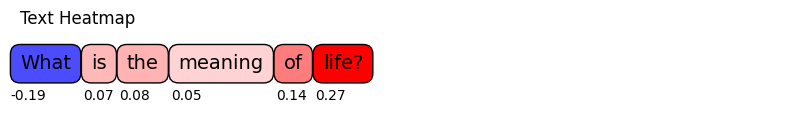

In [15]:
# Function to plot text heatmap
def plot_text_heatmap(words, scores, title="", width=10, height=0.4, verbose=0, max_word_per_line=20, word_spacing=20, score_fontsize=10, save_path=None):
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    ax.set_title(title, loc='left')
    cmap = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
    cmap.set_clim(0, 1)
    canvas = ax.figure.canvas
    t = ax.transData
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    loc_y = -0.2
    for i, (token, score) in enumerate(zip(words, scores)):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        text = ax.text(0.0, loc_y, token, bbox={'facecolor': color, 'pad': 5.0, 'linewidth': 1, 'boxstyle': 'round,pad=0.5'}, transform=t, fontsize=14)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        score_text = ax.text(0.01, loc_y - 1, f"{score:.2f}", transform=t, fontsize=score_fontsize, ha='center')
        score_text.draw(canvas.get_renderer())
        ex_score = score_text.get_window_extent()
        if (i+1) % max_word_per_line == 0:
            loc_y -= 2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width + word_spacing, units='dots')
    if verbose == 0:
        ax.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Define the words for heatmap and save path
words = prompt.split(' ')
save_path = '/kaggle/working/text_heatmap.png'

# Call the function with the save path
plot_text_heatmap(words, coefficients, title="Text Heatmap", save_path=save_path)


## 📚 References

1. **OpenAI.** (2023). *GPT-3.5 and Instruct Models*.  
   Retrieved from https://platform.openai.com/docs

2. **Kusner, M., Sun, Y., Kolkin, N., & Weinberger, K. Q.** (2015).  
   *From Word Embeddings to Document Distances*.  
   In *Proceedings of the 32nd International Conference on Machine Learning (ICML)*.  
   https://proceedings.mlr.press/v37/kusnerb15.html

3. **Mikolov, T., Chen, K., Corrado, G., & Dean, J.** (2013).  
   *Efficient Estimation of Word Representations in Vector Space*.  
   arXiv:1301.3781 [cs.CL].  
   https://code.google.com/archive/p/word2vec/

4. **Ribeiro, M. T., Singh, S., & Guestrin, C.** (2016).  
   *"Why Should I Trust You?": Explaining the Predictions of Any Classifier*.  
   In *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD)*.  
   https://doi.org/10.1145/2939672.2939778

5. **Aslansefat, K., Hashemian, M., Walker, M., Akram, M. N., Sorokos, I., & Papadopoulos, Y.** (2023).  
   *Explaining Black Boxes with a SMILE: Statistical Model-agnostic Interpretability with Local Explanations*.  
   *IEEE Software*, 41(1), 87–97.  
   https://doi.org/10.1109/MS.2023.10112345
